In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import xgboost as xgb
import bisect

from scipy import stats
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN

In [2]:
train = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\train.csv').drop(['X1'], axis=1)
test = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\test.csv').drop(['Id', 'X1'], axis=1)

display(train.head())
display(test.head())

,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,56.3,67.5,22.5,AH32,4,97,PL973,467,2241
1,115.0,67.0,13.0,AH32,2,27,PL271,1058,1163
2,59.2,44.6,18.0,AH32-TM,1,14,PL141,270,1094
3,52.1,97.4,15.0,A,17,24,PL242,391,2604
4,42.9,58.7,14.5,A,4,23,PL233,232,1564


,X2,X3,X4,X5,X6,X7,X8
0,80.6,104.8,11.0,A,29,23,PL234
1,141.8,34.2,17.5,A,2,91,PL911
2,77.2,103.3,17.0,A,10,97,PL973
3,95.5,131.0,18.0,A,2,23,PL234
4,91.7,36.1,19.0,AH32,1,27,PL271


| 항목 | 설명     |
|-----|----------|
| X1  | 작업번호 |
| X2  | 마킹길이 |
| X3  | 절단길이 |
| X4  | 철판두께 |
| X5  | 철판재질 |
| X6  | 절단갯수 |
| X7  | 작업장   |
| X8  | 작업자   |
| Y1  | 마킹시간 |
| Y2  | 절단시간 |

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121754 entries, 0 to 121753
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X2      121754 non-null  float64
 1   X3      121754 non-null  float64
 2   X4      121754 non-null  float64
 3   X5      121754 non-null  object 
 4   X6      121754 non-null  int64  
 5   X7      121754 non-null  int64  
 6   X8      121754 non-null  object 
 7   Y1      121754 non-null  int64  
 8   Y2      121754 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 8.4+ MB


In [4]:
train.describe()

,X2,X3,X4,X6,X7,Y1,Y2
count,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,1.217540e+05,121754.000000
mean,77.608615,73.875636,17.444897,13.630049,43.921152,8.971671e+02,2193.206638
std,48.006125,53.267359,4.498316,20.751914,32.509414,4.604704e+04,2299.585390
min,3.200000,1.800000,6.000000,1.000000,14.000000,0.000000e+00,0.000000
25%,45.200000,40.900000,14.500000,1.000000,22.000000,2.380000e+02,1064.000000
50%,68.100000,52.800000,17.000000,4.000000,25.000000,3.790000e+02,1593.000000
75%,98.300000,93.000000,20.000000,18.000000,91.000000,5.480000e+02,2778.000000
max,524.400000,621.300000,40.000000,416.000000,97.000000,6.157364e+06,348262.000000


# 특징 만들기


In [ ]:
# train['X8'] = train['X8'].str.extract(r'(PL|PS)')
# test['X8'] = test['X8'].str.extract(r'(PL|PS)')

In [ ]:
# train['X8_encoded'] = (train['X8'] != 'PL').astype(int)
# test['X8_encoded'] = (test['X8'] != 'PL').astype(int)

# train = pd.get_dummies(train, columns=['X8_encoded'], prefix=['X8'])
# test = pd.get_dummies(test, columns=['X8_encoded'], prefix=['X8'])

# train[['X8_0', 'X8_1']] = train[['X8_0', 'X8_1']].astype(int)
# test[['X8_0', 'X8_1']] = test[['X8_0', 'X8_1']].astype(int)

In [5]:
mmtime = train.groupby('X5')['Y1'].mean()
mctime = train.groupby('X5')['Y2'].mean()

wmtime = train.groupby('X7')['Y1'].mean()
wctime = train.groupby('X7')['Y2'].mean()

manmtime = train.groupby('X8')['Y1'].mean()
manctime = train.groupby('X8')['Y2'].mean()

train['X5_mmtime'] = train['X5'].map(mmtime)
train['X5_mctime'] = train['X5'].map(mctime)

train['X7_wmtime'] = train['X7'].map(wmtime)
train['X7_wctime'] = train['X7'].map(wctime)

train['X8_manmtime'] = train['X8'].map(manmtime)
train['X8_manctime'] = train['X8'].map(manctime)

test['X5_mmtime'] = test['X5'].map(mmtime)
test['X5_mctime'] = test['X5'].map(mctime)

test['X7_wmtime'] = test['X7'].map(wmtime)
test['X7_wctime'] = test['X7'].map(wctime)

test['X8_manmtime'] = test['X8'].map(manmtime)
test['X8_manctime'] = test['X8'].map(manctime)

In [6]:
import re

def convert_x5(value):
    # -TM 이 포함되어 있으면 제거하고 숫자로 변환, 그렇지 않으면 그냥 숫자로 변환
    if '-TM' in value:
        value = value.replace('-TM', '')
    match = re.search(r'\d+', value)  # 정규표현식을 사용하여 숫자 추출
    if match:
        return int(match.group()) * 9.8
    else:
        return 235  # 숫자가 없는 경우 235로 설정

# X5 열에 변환 함수 적용
train['X5_numeric'] = train['X5'].apply(convert_x5)
test['X5_numeric'] = test['X5'].apply(convert_x5)

train.drop(columns = ['X5'], inplace = True)
test.drop(columns = ['X5'], inplace = True)

In [7]:
def estimate_rotation_speed(X2, X3, X4, X5_numeric, X6):
    rotation_speed = X2 + (X3 / X4) * (X5_numeric / 10) * (X6 / 2)
    return rotation_speed

train['Estimated_Rotation_Speed'] = estimate_rotation_speed(train['X2'], train['X3'], train['X4'], train['X5_numeric'], train['X6'])
test['Estimated_Rotation_Speed'] = estimate_rotation_speed(test['X2'], test['X3'], test['X4'], test['X5_numeric'], test['X6'])

In [8]:
train['X2/X3'] = train['X2'] / train['X3']
test['X2/X3'] = test['X2'] / test['X3']

In [11]:
X2_idx = train[(train['X2'] > 500)].index
X3_idx = train[(train['X3'] > 600)].index
X4_idx = train[(train['X4'] > 36)].index
X6_idx = train[(train['X6'] > 265)].index
Y1_idx = train[(train['Y1'] == 0) | (train['Y1'] > 70000)].index
Y2_idx = train[(train['Y2'] == 0) | (train['Y2'] > 70000)].index

train.loc[X2_idx, 'X2'] = train.loc[(train ['X2'] >= 500), 'X2'].mean()
train.loc[X3_idx, 'X3'] = train.loc[(train ['X3'] >= 600), 'X3'].mean()
train.loc[X4_idx, 'X4'] = train.loc[(train ['X4'] >= 36), 'X4'].mean()
train.loc[X6_idx, 'X6'] = train.loc[(train ['X6'] >= 265), 'X6'].mean()
train.loc[Y1_idx, 'Y1'] = train.loc[(train['Y1'] != 0) & (train['Y1'] <= 70000), 'Y1'].mean()
train.loc[Y2_idx, 'Y2'] = train.loc[(train['Y2'] != 0) & (train['Y2'] <= 70000), 'Y2'].mean()

In [12]:
scaler = MinMaxScaler()

columns_to_scale = ['X2', 'X3', 'X4', 'X6', 'X2/X3', 'Estimated_Rotation_Speed']

train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
test[columns_to_scale] = scaler.transform(test[columns_to_scale])

In [13]:
train

,X2,X3,X4,X6,X7,X8,Y1,Y2,X5_mmtime,X5_mctime,X7_wmtime,X7_wctime,X8_manmtime,X8_manctime,X5_numeric,Estimated_Rotation_Speed,X2/X3
0,0.103873,0.106535,0.549686,0.008772,97,PL973,467.0,2241.0,588.517493,2255.398250,424.774954,2635.545978,414.072878,2632.468069,313.6,0.001379,0.009845
1,0.218701,0.105724,0.233200,0.002924,27,PL271,1058.0,1163.0,588.517493,2255.398250,512.662090,1440.456061,590.812157,1489.384339,313.6,0.001566,0.020675
2,0.109546,0.069402,0.399772,0.000000,14,PL141,270.0,1094.0,314.389561,1561.396820,304.917220,1160.583795,298.877326,1162.634690,313.6,0.000530,0.015900
3,0.095657,0.155019,0.299829,0.046784,24,PL242,391.0,2604.0,951.562925,2206.966183,538.719053,2867.222400,546.286353,2992.967657,235.0,0.007786,0.006173
4,0.077660,0.092265,0.283172,0.008772,23,PL233,232.0,1564.0,951.562925,2206.966183,406.549153,3019.517627,385.282033,2913.487235,235.0,0.001314,0.008578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121749,0.186228,0.142209,0.133257,0.020468,21,PS213,906.0,1226.0,906.000000,1226.000000,568.374486,2918.445885,531.624726,2584.399671,235.0,0.005412,0.013102
121750,0.087637,0.079779,0.566343,0.000000,23,PL231,175.0,1540.0,175.000000,1540.000000,406.549153,3019.517627,441.762766,3215.477385,352.8,0.000467,0.011159
121751,0.076878,0.046052,0.932801,0.011696,27,PL272,376.0,1492.0,376.000000,1492.000000,512.662090,1440.456061,585.325622,1431.167574,352.8,0.000662,0.016881
121752,0.036972,0.021891,0.999429,0.020468,97,PL973,85.0,723.0,609.500000,3930.750000,424.774954,2635.545978,414.072878,2632.468069,352.8,0.000437,0.017337


In [ ]:
# exclude_columns = ['cluster']

# num_columns = len(filtered_train.columns) - len(exclude_columns)
# num_rows = (num_columns - 1) // 4 + 1 

# fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, num_rows * 4))
# axes = axes.flatten()

# index = 0
# for i, column in enumerate(filtered_train.columns):
#     if column not in exclude_columns:
#         sns.histplot(data=filtered_train, x=column, kde=True, ax=axes[index])
#         axes[index].set_title(f'Histogram of {column}')
#         axes[index].set_xlabel('Values')
#         axes[index].set_ylabel('Frequency')
#         index += 1

# for i in range(index, len(axes)):
#     fig.delaxes(axes[i])

# plt.tight_layout()  
# plt.show()

In [14]:
train['Y1'] = np.log1p(train['Y1'])
train['Y2'] = np.log1p(train['Y2'])

<Axes: >

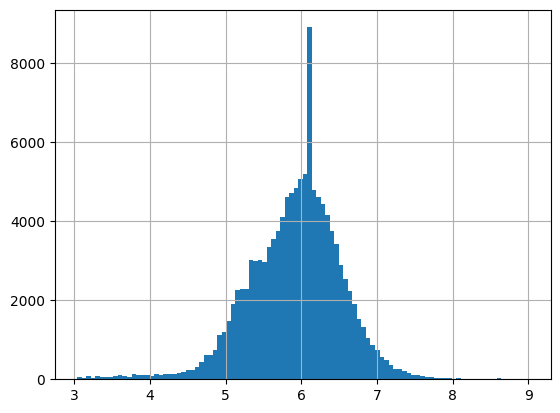

In [15]:
train = train[(train['Y1'] > 3) & (train['Y1'] < 9)]
train['Y1'].hist(bins=100)

<Axes: >

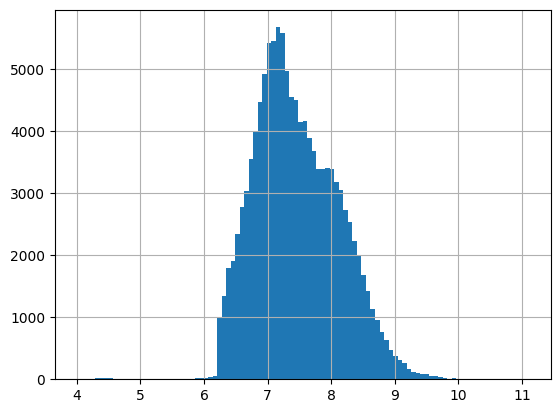

In [16]:
train = train[(train['Y2'] > 4) & (train['Y1'] < 10)]
train['Y2'].hist(bins=100)

## CatBoost

In [17]:
cat_y1 = CatBoostRegressor(loss_function='MAE',
                           cat_features=['X8'],  # Add categorical features index if any
                           verbose=50
                           )

X_train_reduced = train.drop(columns=['Y1', 'Y2']).reset_index(drop=True)
y_train = train['Y1'].reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    cat_y1.fit(X_t, y_t, eval_set=(X_val, y_val))

    val_pred = cat_y1.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    test = test[X_train_reduced.columns]

    cat_pred = cat_y1.predict(test)
    cat_pred = np.where(cat_pred < 0, 0, cat_pred)

    ensemble_predictions.append(cat_pred)

final_predictions_y1 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.4614019	test: 0.4621993	best: 0.4621993 (0)	total: 202ms	remaining: 3m 21s
50:	learn: 0.2529720	test: 0.2534831	best: 0.2534831 (50)	total: 3.65s	remaining: 1m 7s
100:	learn: 0.2141453	test: 0.2146596	best: 0.2146596 (100)	total: 6.75s	remaining: 1m
150:	learn: 0.2026699	test: 0.2032631	best: 0.2032631 (150)	total: 9.61s	remaining: 54s
200:	learn: 0.1975569	test: 0.1982917	best: 0.1982917 (200)	total: 12.9s	remaining: 51.2s
250:	learn: 0.1944218	test: 0.1953493	best: 0.1953493 (250)	total: 15.7s	remaining: 46.9s
300:	learn: 0.1922373	test: 0.1933730	best: 0.1933730 (300)	total: 19.1s	remaining: 44.4s
350:	learn: 0.1906462	test: 0.1919901	best: 0.1919901 (350)	total: 22.5s	remaining: 41.5s
400:	learn: 0.1892387	test: 0.1907737	best: 0.1907737 (400)	total: 25.6s	remaining: 38.3s
450:	learn: 0.1880434	test: 0.1897419	best: 0.1897419 (450)	total: 28.7s	remaining: 34.9s
500:	learn: 0.1870202	test: 0.1888953	best: 0.1888953 (500)	total: 32.3s	remaining: 32.2s
550:	learn: 0.186051

Processing folds:  20%|██        | 1/5 [01:02<04:11, 62.98s/it]

999:	learn: 0.1807333	test: 0.1841668	best: 0.1841668 (999)	total: 1m 2s	remaining: 0us

bestTest = 0.1841668488
bestIteration = 999

0:	learn: 0.4612103	test: 0.4628847	best: 0.4628847 (0)	total: 70.3ms	remaining: 1m 10s
50:	learn: 0.2525725	test: 0.2556501	best: 0.2556501 (50)	total: 3.23s	remaining: 1m
100:	learn: 0.2137145	test: 0.2166088	best: 0.2166088 (100)	total: 6.09s	remaining: 54.3s
150:	learn: 0.2020870	test: 0.2052680	best: 0.2052680 (150)	total: 9.03s	remaining: 50.7s
200:	learn: 0.1968053	test: 0.2001319	best: 0.2001319 (200)	total: 12s	remaining: 47.7s
250:	learn: 0.1939074	test: 0.1973913	best: 0.1973913 (250)	total: 14.8s	remaining: 44.3s
300:	learn: 0.1917753	test: 0.1953203	best: 0.1953203 (300)	total: 17.7s	remaining: 41.1s
350:	learn: 0.1901791	test: 0.1938177	best: 0.1938177 (350)	total: 20.6s	remaining: 38s
400:	learn: 0.1888366	test: 0.1925389	best: 0.1925389 (400)	total: 23.4s	remaining: 34.9s
450:	learn: 0.1876144	test: 0.1914296	best: 0.1914296 (450)	total: 

Processing folds:  40%|████      | 2/5 [02:05<03:07, 62.43s/it]

999:	learn: 0.1804290	test: 0.1857718	best: 0.1857718 (999)	total: 1m 1s	remaining: 0us

bestTest = 0.1857717914
bestIteration = 999

0:	learn: 0.4613684	test: 0.4625181	best: 0.4625181 (0)	total: 65.6ms	remaining: 1m 5s
50:	learn: 0.2526326	test: 0.2544165	best: 0.2544165 (50)	total: 3.04s	remaining: 56.5s
100:	learn: 0.2135928	test: 0.2162451	best: 0.2162451 (100)	total: 6.01s	remaining: 53.5s
150:	learn: 0.2021662	test: 0.2049739	best: 0.2049739 (150)	total: 8.84s	remaining: 49.7s
200:	learn: 0.1970359	test: 0.1998766	best: 0.1998766 (200)	total: 11.7s	remaining: 46.5s
250:	learn: 0.1940744	test: 0.1969683	best: 0.1969683 (250)	total: 14.6s	remaining: 43.5s
300:	learn: 0.1920477	test: 0.1949349	best: 0.1949349 (300)	total: 17.5s	remaining: 40.7s
350:	learn: 0.1904680	test: 0.1934146	best: 0.1934146 (350)	total: 20.4s	remaining: 37.8s
400:	learn: 0.1891065	test: 0.1921084	best: 0.1921084 (400)	total: 23.4s	remaining: 34.9s
450:	learn: 0.1878388	test: 0.1909134	best: 0.1909134 (450)	t

Processing folds:  60%|██████    | 3/5 [03:04<02:02, 61.15s/it]

999:	learn: 0.1805183	test: 0.1851406	best: 0.1851406 (999)	total: 59.2s	remaining: 0us

bestTest = 0.1851405899
bestIteration = 999

0:	learn: 0.4610521	test: 0.4624729	best: 0.4624729 (0)	total: 63.9ms	remaining: 1m 3s
50:	learn: 0.2530679	test: 0.2530178	best: 0.2530178 (50)	total: 3.08s	remaining: 57.3s
100:	learn: 0.2142321	test: 0.2135417	best: 0.2135417 (100)	total: 5.99s	remaining: 53.3s
150:	learn: 0.2027287	test: 0.2019463	best: 0.2019463 (150)	total: 8.85s	remaining: 49.8s
200:	learn: 0.1976775	test: 0.1970697	best: 0.1970697 (200)	total: 11.8s	remaining: 47s
250:	learn: 0.1946401	test: 0.1942607	best: 0.1942607 (250)	total: 14.8s	remaining: 44.1s
300:	learn: 0.1925383	test: 0.1923317	best: 0.1923317 (300)	total: 17.7s	remaining: 41.1s
350:	learn: 0.1909263	test: 0.1908893	best: 0.1908893 (350)	total: 20.6s	remaining: 38.1s
400:	learn: 0.1895050	test: 0.1896479	best: 0.1896479 (400)	total: 24s	remaining: 35.9s
450:	learn: 0.1883130	test: 0.1885722	best: 0.1885722 (450)	total

Processing folds:  80%|████████  | 4/5 [04:04<01:00, 60.49s/it]

999:	learn: 0.1808742	test: 0.1827740	best: 0.1827740 (999)	total: 59s	remaining: 0us

bestTest = 0.1827739831
bestIteration = 999

0:	learn: 0.4625582	test: 0.4575328	best: 0.4575328 (0)	total: 93.1ms	remaining: 1m 33s
50:	learn: 0.2538035	test: 0.2493060	best: 0.2493060 (50)	total: 3.13s	remaining: 58.2s
100:	learn: 0.2148475	test: 0.2110194	best: 0.2110194 (100)	total: 6.05s	remaining: 53.9s
150:	learn: 0.2030319	test: 0.1995321	best: 0.1995321 (150)	total: 8.96s	remaining: 50.4s
200:	learn: 0.1980544	test: 0.1948510	best: 0.1948510 (200)	total: 12s	remaining: 47.5s
250:	learn: 0.1950086	test: 0.1920851	best: 0.1920851 (250)	total: 15s	remaining: 44.8s
300:	learn: 0.1929542	test: 0.1902542	best: 0.1902542 (300)	total: 17.9s	remaining: 41.6s
350:	learn: 0.1912042	test: 0.1887653	best: 0.1887653 (350)	total: 20.7s	remaining: 38.3s
400:	learn: 0.1899176	test: 0.1877224	best: 0.1877224 (400)	total: 23.4s	remaining: 35s
450:	learn: 0.1887467	test: 0.1867703	best: 0.1867703 (450)	total: 2

Processing folds: 100%|██████████| 5/5 [05:01<00:00, 60.28s/it]

999:	learn: 0.1815037	test: 0.1812752	best: 0.1812752 (999)	total: 56.8s	remaining: 0us

bestTest = 0.181275219
bestIteration = 999

Validation : MAE scores for each fold: [0.18416784836804856, 0.18576638530559025, 0.18514159603080904, 0.18276657867902593, 0.1812600721669591]
Validation : MAE: 0.18382049611008658


In [18]:
cat_y2 = CatBoostRegressor(loss_function='MAE',
                           cat_features=['X8'],  # Add categorical features index if any
                           verbose=50
                           )

X_train_reduced = train.drop(columns=['Y1', 'Y2']).reset_index(drop=True)
y_train = train['Y2'].reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    cat_y2.fit(X_t, y_t, eval_set=(X_val, y_val))

    val_pred = cat_y2.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    cat_pred = cat_y2.predict(test)
    cat_pred = np.where(cat_pred < 0, 0, cat_pred)

    ensemble_predictions.append(cat_pred)

final_predictions_y2 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.5235272	test: 0.5234827	best: 0.5234827 (0)	total: 69ms	remaining: 1m 8s
50:	learn: 0.2075696	test: 0.2060667	best: 0.2060667 (50)	total: 3.23s	remaining: 1m
100:	learn: 0.1374680	test: 0.1356953	best: 0.1356953 (100)	total: 6.4s	remaining: 56.9s
150:	learn: 0.1159093	test: 0.1140846	best: 0.1140846 (150)	total: 9.76s	remaining: 54.9s
200:	learn: 0.1080264	test: 0.1062439	best: 0.1062439 (200)	total: 12.6s	remaining: 50.2s
250:	learn: 0.1042885	test: 0.1025334	best: 0.1025334 (250)	total: 15.4s	remaining: 46s
300:	learn: 0.1017778	test: 0.1000181	best: 0.1000181 (300)	total: 18.7s	remaining: 43.4s
350:	learn: 0.0999273	test: 0.0981882	best: 0.0981882 (350)	total: 21.9s	remaining: 40.4s
400:	learn: 0.0987285	test: 0.0970547	best: 0.0970547 (400)	total: 24.6s	remaining: 36.7s
450:	learn: 0.0975523	test: 0.0959091	best: 0.0959091 (450)	total: 27.5s	remaining: 33.4s
500:	learn: 0.0965273	test: 0.0949208	best: 0.0949208 (500)	total: 30.5s	remaining: 30.4s
550:	learn: 0.0955873	t

Processing folds:  20%|██        | 1/5 [01:02<04:11, 62.80s/it]

999:	learn: 0.0915752	test: 0.0905605	best: 0.0905605 (999)	total: 1m 2s	remaining: 0us

bestTest = 0.09056051148
bestIteration = 999

0:	learn: 0.5240412	test: 0.5243842	best: 0.5243842 (0)	total: 56.1ms	remaining: 56.1s
50:	learn: 0.2065341	test: 0.2086960	best: 0.2086960 (50)	total: 3.18s	remaining: 59.2s
100:	learn: 0.1370482	test: 0.1392309	best: 0.1392309 (100)	total: 6.2s	remaining: 55.2s
150:	learn: 0.1152937	test: 0.1173261	best: 0.1173261 (150)	total: 9.11s	remaining: 51.2s
200:	learn: 0.1073530	test: 0.1094254	best: 0.1094254 (200)	total: 12.1s	remaining: 48.2s
250:	learn: 0.1032182	test: 0.1053224	best: 0.1053224 (250)	total: 15s	remaining: 44.8s
300:	learn: 0.1007040	test: 0.1029054	best: 0.1029054 (300)	total: 19s	remaining: 44.2s
350:	learn: 0.0989512	test: 0.1012428	best: 0.1012428 (350)	total: 22.4s	remaining: 41.4s
400:	learn: 0.0976597	test: 0.1000184	best: 0.1000184 (400)	total: 25.5s	remaining: 38.1s
450:	learn: 0.0965066	test: 0.0989261	best: 0.0989261 (450)	total

Processing folds:  40%|████      | 2/5 [02:06<03:09, 63.23s/it]

999:	learn: 0.0906832	test: 0.0938029	best: 0.0938029 (999)	total: 1m 3s	remaining: 0us

bestTest = 0.0938028518
bestIteration = 999

0:	learn: 0.5235372	test: 0.5223281	best: 0.5223281 (0)	total: 68.1ms	remaining: 1m 8s
50:	learn: 0.2095229	test: 0.2100559	best: 0.2100559 (50)	total: 3.1s	remaining: 57.7s
100:	learn: 0.1379561	test: 0.1385126	best: 0.1385126 (100)	total: 6.06s	remaining: 54s
150:	learn: 0.1159308	test: 0.1165262	best: 0.1165262 (150)	total: 8.92s	remaining: 50.2s
200:	learn: 0.1078705	test: 0.1084527	best: 0.1084527 (200)	total: 11.7s	remaining: 46.7s
250:	learn: 0.1039416	test: 0.1046855	best: 0.1046855 (250)	total: 14.7s	remaining: 43.8s
300:	learn: 0.1014696	test: 0.1023081	best: 0.1023081 (300)	total: 18.3s	remaining: 42.5s
350:	learn: 0.0996431	test: 0.1004660	best: 0.1004660 (350)	total: 21.7s	remaining: 40.2s
400:	learn: 0.0982317	test: 0.0990717	best: 0.0990717 (400)	total: 25s	remaining: 37.4s
450:	learn: 0.0970207	test: 0.0978478	best: 0.0978478 (450)	total:

Processing folds:  60%|██████    | 3/5 [03:08<02:05, 62.55s/it]

999:	learn: 0.0910886	test: 0.0921202	best: 0.0921202 (999)	total: 1m 1s	remaining: 0us

bestTest = 0.09212017137
bestIteration = 999

0:	learn: 0.5223543	test: 0.5266674	best: 0.5266674 (0)	total: 55.8ms	remaining: 55.8s
50:	learn: 0.2082693	test: 0.2100440	best: 0.2100440 (50)	total: 3.03s	remaining: 56.3s
100:	learn: 0.1373912	test: 0.1381524	best: 0.1381524 (100)	total: 5.94s	remaining: 52.9s
150:	learn: 0.1159313	test: 0.1166579	best: 0.1166579 (150)	total: 8.69s	remaining: 48.8s
200:	learn: 0.1078614	test: 0.1085864	best: 0.1085864 (200)	total: 11.5s	remaining: 45.8s
250:	learn: 0.1036987	test: 0.1044063	best: 0.1044063 (250)	total: 14.3s	remaining: 42.6s
300:	learn: 0.1012266	test: 0.1019283	best: 0.1019283 (300)	total: 17.1s	remaining: 39.8s
350:	learn: 0.0994608	test: 0.1001891	best: 0.1001891 (350)	total: 20s	remaining: 36.9s
400:	learn: 0.0981375	test: 0.0988753	best: 0.0988753 (400)	total: 22.7s	remaining: 33.9s
450:	learn: 0.0970068	test: 0.0977466	best: 0.0977466 (450)	to

Processing folds:  80%|████████  | 4/5 [04:06<01:01, 61.09s/it]

999:	learn: 0.0910870	test: 0.0922370	best: 0.0922370 (999)	total: 58.4s	remaining: 0us

bestTest = 0.09223701904
bestIteration = 999

0:	learn: 0.5238356	test: 0.5204977	best: 0.5204977 (0)	total: 67ms	remaining: 1m 6s
50:	learn: 0.2091565	test: 0.2067267	best: 0.2067267 (50)	total: 3.34s	remaining: 1m 2s
100:	learn: 0.1372691	test: 0.1362189	best: 0.1362189 (100)	total: 6.57s	remaining: 58.5s
150:	learn: 0.1156457	test: 0.1149704	best: 0.1149704 (150)	total: 9.44s	remaining: 53.1s
200:	learn: 0.1077553	test: 0.1071727	best: 0.1071727 (200)	total: 12.2s	remaining: 48.7s
250:	learn: 0.1037987	test: 0.1033628	best: 0.1033628 (250)	total: 15s	remaining: 44.9s
300:	learn: 0.1012718	test: 0.1009797	best: 0.1009797 (300)	total: 17.9s	remaining: 41.6s
350:	learn: 0.0995759	test: 0.0994283	best: 0.0994283 (350)	total: 21.4s	remaining: 39.5s
400:	learn: 0.0982140	test: 0.0981983	best: 0.0981983 (400)	total: 24.3s	remaining: 36.3s
450:	learn: 0.0970259	test: 0.0971074	best: 0.0971074 (450)	tota

Processing folds: 100%|██████████| 5/5 [05:07<00:00, 61.42s/it]

999:	learn: 0.0911189	test: 0.0919897	best: 0.0919897 (999)	total: 59.8s	remaining: 0us

bestTest = 0.09198971598
bestIteration = 999

Validation : MAE scores for each fold: [0.09056151058446214, 0.09402978786546977, 0.09223764569753677, 0.09229843382364444, 0.09229474413926321]
Validation : MAE: 0.09228442442207527


## MLJAR

In [ ]:
!pip install mljar-supervised

In [ ]:
categorical_features = ['X8']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

In [ ]:
from supervised.automl import AutoML

train_x1 = train.drop(['Y1', 'Y2'], axis=1)
train_x2 = train.drop(['Y1', 'Y2'], axis=1)

train_y1 = train['Y1']
train_y2 = train['Y2']


Cross_validation = {
    "validation_type": "kfold",
    "k_folds": 10,
    "shuffle": True,
    "random_seed": 112
}

In [ ]:
automl_y1 = AutoML(mode="Compete", algorithms = ['Decision Tree', 'LightGBM', 'Xgboost', 'CatBoost'],
                n_jobs = -1, eval_metric='mae', validation_strategy=Cross_validation, ml_task = "regression",
                   total_time_limit = 1800 * 2 * 5)
automl_y1.fit(train_x1, train_y1)

In [ ]:
automl_y2 = AutoML(mode="Compete", algorithms = ['Decision Tree', 'LightGBM', 'Xgboost', 'CatBoost'],
                n_jobs = -1, eval_metric='mae', validation_strategy=Cross_validation, ml_task = "regression",
                   total_time_limit=1800 * 2 * 5)
automl_y2.fit(train_x2, train_y2)

In [ ]:
pred_y1 = automl_y1.predict_all(test)
pred_y2 = automl_y2.predict_all(test)

In [ ]:
final_predictions = (np.expm1(pred_y1)) + (np.expm1(pred_y2))

## 제출

In [19]:
submit = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\sample_submission.csv')

submit.head()

,Id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [20]:
final_predictions = np.expm1(final_predictions_y1) + np.expm1(final_predictions_y2)


submit.iloc[:, 1] = final_predictions

submit

,Id,Predicted
0,0,2835.442912
1,1,1684.013484
2,2,3209.953254
3,3,4114.524269
4,4,1356.998399
...,...,...
40566,40566,822.345998
40567,40567,1318.547007
40568,40568,2140.209076
40569,40569,1132.893406


In [21]:
submit.to_csv('C:\\Users\\dlwks\\OneDrive\\바탕 화면\\VSCode\\HD_CNC\\1123-1.csv', index=False)